# Import ocean data from CMEMS



The final step at the CMEMS web portal provides you also a script to download the data.
The following command download CMEMS data using the motu-client. The CMEMS portal give a script like the following matching you search criteria:

```bash
python -m  motu-client --user "abarth" --pwd  "your*password"  \
  --motu http://nrt.cmems-du.eu/motu-web/Motu \
  --service-id MEDSEA_ANALYSIS_FORECAST_PHY_006_013-TDS \
  --product-id sv04-med-ingv-tem-an-fc-d \
  --longitude-min -17.29166603088379 --longitude-max 36.29166793823242 \
  --latitude-min 30.1875 --latitude-max 45.97916793823242 \
  --date-min "2019-04-24 00:00:00" --date-max "2019-04-24 00:00:00" \
  --depth-min 1.0181 --depth-max 104.94500000000001 \
  --variable thetao --out-dir Data 
  --out-name Data/sv04-med-ingv-tem-an-fc-d_1555334258448.nc
```


Import the necessary modules for linear algebra (the transpose operator), plotting via matplotlib and reading NetCDF Files 


In [1]:
using LinearAlgebra
using PyCall
using PyCall: PyObject
using PyPlot
using NCDatasets
using Statistics
using Dates

Some helper functions to make plotting data with missing values easier

In [2]:
function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
  numpy_ma = pyimport("numpy").ma
  pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

PyObject(a::Adjoint{Array}) = PyObject(copy(a))

PyObject

# Load model data
Name of the downloaded NetCDF file

In [24]:
filename = "Data/sv04-med-ingv-tem-an-fc-d_1555334258448.nc"
if !isfile(filename)
    download("https://dox.ulg.ac.be/index.php/s/vW04ZCB5HOpyKI6/download",filename)
end

List the metadata of the NetCDF file

In [4]:
ds = Dataset(filename)

NCDataset: Data/sv04-med-ingv-tem-an-fc-d_1555334258448.nc
Group: /

Dimensions
   time = 1
   depth = 25
   lat = 380
   lon = 1287

Variables
  depth   (25)
    Datatype:    Float32
    Dimensions:  depth
    Attributes:
     units                = m
     nav_model            = Grid T
     positive             = down
     standard_name        = depth
     long_name            = depth
     axis                 = Z
     valid_min            = 1.0182366
     valid_max            = 104.94398
     _ChunkSizes          = 141
     _CoordinateAxisType  = Height
     _CoordinateZisPositive = down

  thetao   (1287 × 380 × 25 × 1)
    Datatype:    Float32
    Dimensions:  lon × lat × depth × time
    Attributes:
     _FillValue           = 1.0e20
     missing_value        = 1.0e20
     units                = degC
     coordinates          = time depth lat lon
     standard_name        = sea_water_potential_temperature
     long_name            = temperature
     _ChunkSizes          = Int32[1,

The time instance in the NetCDF file

In [5]:
ds["time"][:]

1-element Array{DateTime,1}:
 2019-04-24T00:00:00

The depth (in m) for the first level:

In [6]:
ds["depth"][1]

1.0182366f0

Load the first layer and the first time instance:

In [7]:
SST = ds["thetao"][:,:,1,1];

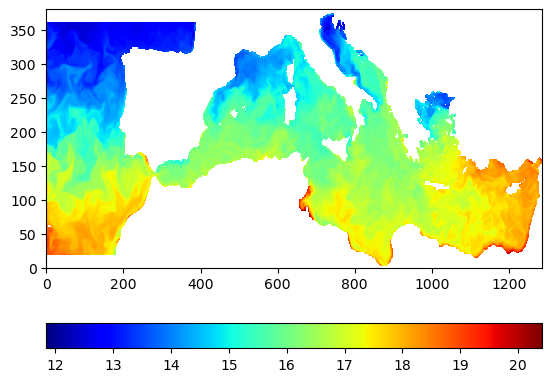

In [8]:
pcolor(SST', cmap="jet"); colorbar(orientation="horizontal");

A nicer plot with longitude and latitude as axes and the correct aspect ratio:

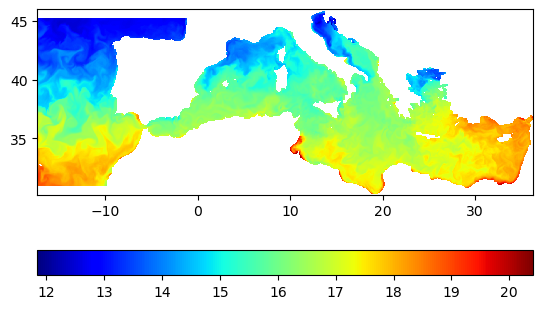

In [9]:
lon = ds["lon"][:];
lat = ds["lat"][:];
pcolor(lon,lat,SST', cmap="jet"); colorbar(orientation="horizontal");
gca().set_aspect(1/cos(pi*mean(lat) / 180))

List a depth levels in the NetCDF file

In [10]:
depth = ds["depth"][:]

25-element Array{Float32,1}:
   1.0182366
   3.1657474
   5.4649634
   7.9203773
  10.536604
  13.318384
  16.270586
  19.39821
  22.706392
  26.2004
  29.885643
  33.767673
  37.852192
  42.14504
  46.65221
  51.37986
  56.334286
  61.521957
  66.94949
  72.62369
  78.5515
  84.74004
  91.19663
  97.92873
 104.94398

Plot a vertical section at a constant latitude:

In [11]:
j = 200;
T = ds["thetao"][:,j,:,1];
lat[j]

38.479168f0

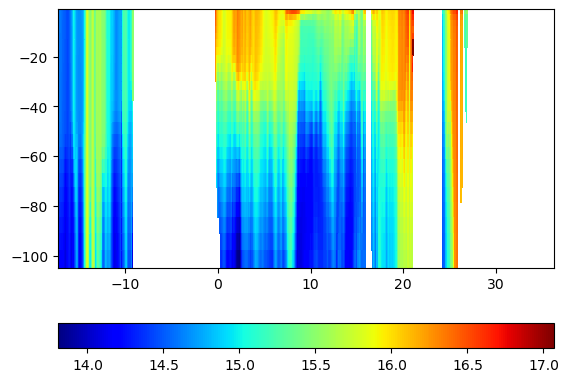

In [12]:
pcolor(lon,-depth,T'; cmap="jet"); colorbar(orientation="horizontal");

# In situ observations

The module PhysOcean can be installed with
```julia
using Pkg
Pkg.add("PhysOcean")
```

In [13]:
using PhysOcean

In [14]:
# username = "Joe"
# password = "p*ssw0rd"

username, password = split(read(expanduser("~/.cmems-credentials"),String),":", limit = 2);

Download temperature data within the specificed time range for any location. Unfortunatelty the ftp URLs change from time to time. You might need to check data prhttps://resources.marine.copernicus.eu/ or 

In [15]:
# range of longitude
lonr = [7.6, 12.2]
# range of latitude
latr = [42., 44.5]
# time range
timerange = [DateTime(2016,4,1),DateTime(2016,6,1)]
param = "TEMP"
basedir = "InSitu-Data"
files = CMEMS.download(lonr,latr,timerange,param,username,password,basedir; 
    indexURLs = ["ftp://my.cmems-du.eu/Core/INSITU_GLO_UV_L2_REP_OBSERVATIONS_013_044/drifter/index_history.txt"])

72-element Array{String,1}:
 "my.cmems-du.eu/Core/INSITU_GLO_UV_L2_REP_OBSERVATIONS_013_044/drifter/history/GL_TS_DC_132549_4600532.nc"
 "my.cmems-du.eu/Core/INSITU_GLO_UV_L2_REP_OBSERVATIONS_013_044/drifter/history/GL_TS_DC_132550_2200623.nc"
 "my.cmems-du.eu/Core/INSITU_GLO_UV_L2_REP_OBSERVATIONS_013_044/drifter/history/GL_TS_DC_132551_2100580.nc"
 "my.cmems-du.eu/Core/INSITU_GLO_UV_L2_REP_OBSERVATIONS_013_044/drifter/history/GL_TS_DC_132552_2100853.nc"
 "my.cmems-du.eu/Core/INSITU_GLO_UV_L2_REP_OBSERVATIONS_013_044/drifter/history/GL_TS_DC_132555_2100856.nc"
 "my.cmems-du.eu/Core/INSITU_GLO_UV_L2_REP_OBSERVATIONS_013_044/drifter/history/GL_TS_DC_132556_2100544.nc"
 "my.cmems-du.eu/Core/INSITU_GLO_UV_L2_REP_OBSERVATIONS_013_044/drifter/history/GL_TS_DC_114538_2100921.nc"
 "my.cmems-du.eu/Core/INSITU_GLO_UV_L2_REP_OBSERVATIONS_013_044/drifter/history/GL_TS_DC_132594_2100944.nc"
 "my.cmems-du.eu/Core/INSITU_GLO_UV_L2_REP_OBSERVATIONS_013_044/drifter/history/GL_TS_DC_132595_2100951.nc"


### Loading a single drifter file

In [19]:
fname = "GL_TS_DB_4700539.nc"
if !isfile(fname)
    download("https://dox.ulg.ac.be/index.php/s/jNvzBhIZgH3861H/download",fname)
end

ds = Dataset(fname);
lon = ds["LONGITUDE"][:];
lat = ds["LATITUDE"][:];
T = ds["TEMP"][:];
obstime = ds["TIME"][:];
close(ds)
sel = .!ismissing.(T[1,:]);
@show sum(sel)
@show extrema(obstime[sel])

sum(sel) = 20647
extrema(obstime[sel]) = (DateTime("2016-03-08T20:00:00"), DateTime("2018-12-31T23:00:00"))


(DateTime("2016-03-08T20:00:00"), DateTime("2018-12-31T23:00:00"))

### Plotting a drifter trajectory

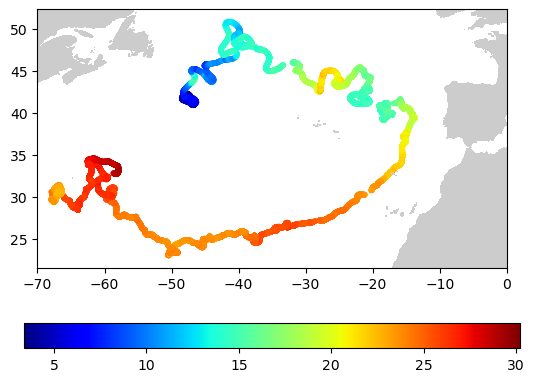

In [20]:
using OceanPlot
scatter(lon[sel],lat[sel],10,T[sel],cmap="jet")
colorbar(orientation = "horizontal")
xlim(-70,0)
OceanPlot.plotmap()
gca().set_aspect(1/cos(pi*mean(ylim()) / 180))